In [1]:
import time
import pickle
import ipdb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection, PatchCollection

In [2]:
from pydrake.solvers import MathematicalProgram, Solve, MosekSolver
from pydrake.planning import GcsTrajectoryOptimization
from pydrake.geometry.optimization import Point, GraphOfConvexSetsOptions, VPolytope
# from pydrake.geometry.optimization import HPolyhedron, Iris, IrisOptions, VPolytope

from floorplan import get_dests, get_floorplan_image, get_lines, get_rects, get_sources

In [3]:
if MosekSolver().enabled():
    print("It looks like you have a Mosek license")

It looks like you have a Mosek license


In [4]:
image = get_floorplan_image()
lines = get_lines()
rects = get_rects()
dests = get_dests()
srcs = get_sources()

with open("iris_polygons3.pkl", "rb") as f:
    free_polys = pickle.load(f)

scale = 1e3
lines = lines / scale
rects = rects / scale
dests = dests / scale
srcs = srcs / scale

dests = dests[:-1] # Remove last redundant destination point

In [5]:
gcs = GcsTrajectoryOptimization(2)

convex_sets = []    
for free_poly in free_polys:
    convex_sets.append(VPolytope(free_poly.T))

tic = time.time()
regions = gcs.AddRegions(regions=convex_sets, order=3)
toc = time.time()

print(toc - tic)

38.79352617263794


In [6]:
source = gcs.AddRegions([Point(srcs[0, :])], order=0)
target = gcs.AddRegions([Point(dests[0, :])], order=0)
gcs.AddEdges(source, regions)
gcs.AddEdges(regions, target)

In [7]:
gcs.AddTimeCost()
gcs.AddPathLengthCost()
gcs.AddVelocityBounds(lb=np.array([-0.1, -0.1]), ub=np.array([0.1, 0.1]))

options = GraphOfConvexSetsOptions()
options.preprocessing = True
options.max_rounded_paths = 20
start_time = time.time()
traj, result = gcs.SolvePath(source, target, options)
print(f"GCS solved in {time.time() - start_time} seconds")
if not result.is_success():
    print("Could not find a feasible path from source to destination")

# fig.savefig("floorplan_final.pdf")

INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 22 rounding trials.


GCS solved in 9.946177959442139 seconds


In [8]:
step_size = 0.1
timestamps = np.arange(traj.start_time(), traj.end_time(), step_size)
print(timestamps)
print(len(timestamps))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1]
72


In [9]:
pos = []
for t in timestamps:
    pos.append(traj.value(t).reshape(1, 2)[0])
pos = np.array(pos)

path_length = 0
for t in range(len(pos) - 1):
    path_length += np.linalg.norm(pos[t+1] - pos[t])
    
print(path_length)

0.7422646329025553


In [10]:
pos
# print(len(position_traj))

array([[1.524     , 2.096     ],
       [1.5339999 , 2.08950548],
       [1.5439999 , 2.0830109 ],
       [1.5539999 , 2.07651632],
       [1.5639999 , 2.07002174],
       [1.5739999 , 2.06352716],
       [1.58385081, 2.05686031],
       [1.59080489, 2.04686031],
       [1.59442012, 2.03686031],
       [1.59685474, 2.02686031],
       [1.59928937, 2.01686031],
       [1.601724  , 2.00686031],
       [1.60415862, 1.99686031],
       [1.60659325, 1.98686031],
       [1.60902787, 1.97686031],
       [1.61146249, 1.9668603 ],
       [1.61389712, 1.9568603 ],
       [1.61633174, 1.9468603 ],
       [1.61876636, 1.9368603 ],
       [1.62120098, 1.9268603 ],
       [1.6236356 , 1.9168603 ],
       [1.62607022, 1.9068603 ],
       [1.62850484, 1.8968603 ],
       [1.63093946, 1.8868603 ],
       [1.63337408, 1.8768603 ],
       [1.6358087 , 1.8668603 ],
       [1.63824332, 1.8568603 ],
       [1.63784172, 1.8468603 ],
       [1.63636027, 1.8368603 ],
       [1.63487881, 1.8268603 ],
       [1.

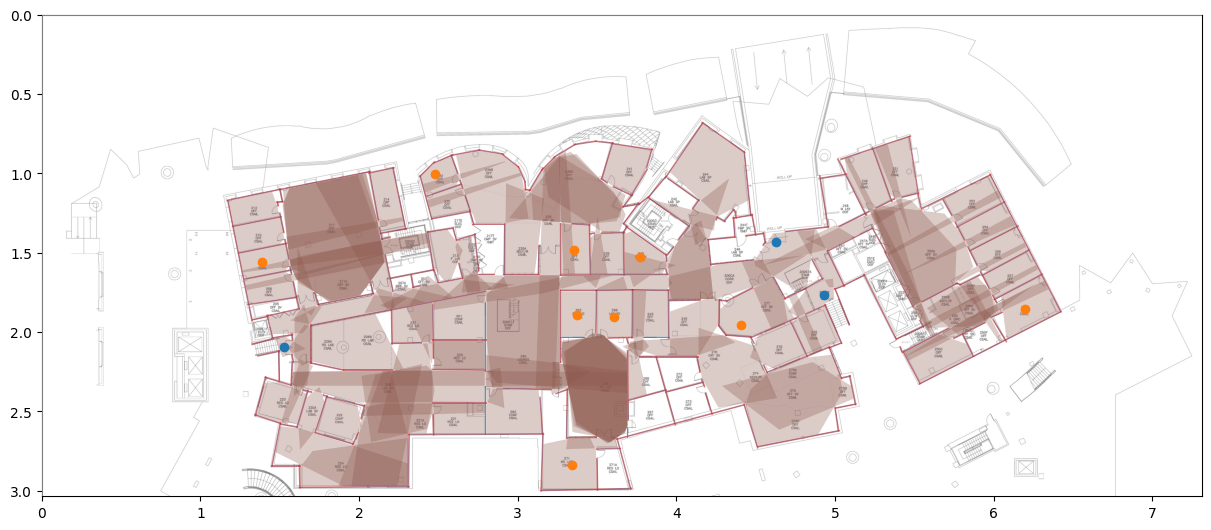

In [11]:
imshow_extent = np.array([-0.5, image.width - 0.5, image.height - 0.5, -0.5])
imshow_extent = imshow_extent / scale

fig, ax = plt.subplots(figsize=(12, 10), layout="constrained")
ax.imshow(image, extent=imshow_extent, alpha=0.5, zorder=3)
col = LineCollection(lines, linewidth=0.2, color="C0", zorder=5)
ax.add_collection(col)

# Plot walls.
patches = []
for rect in rects:
    patches.append(plt.Polygon(rect, closed=True))
col = PatchCollection(patches, facecolor="C3", alpha=0.6, zorder=4)
ax.add_collection(col)

# Plot dests.
ax.scatter(dests[:, 0], dests[:, 1], color="C1", zorder=6)

# Plot sources.
ax.scatter(srcs[:, 0], srcs[:, 1], color="C0", zorder=6)

# Plot iris regions.
patches = []
for free_poly in free_polys:
    patches.append(plt.Polygon(free_poly, closed=True))
col = PatchCollection(patches, facecolor="C5", alpha=0.3, zorder=4)
ax.add_collection(col)

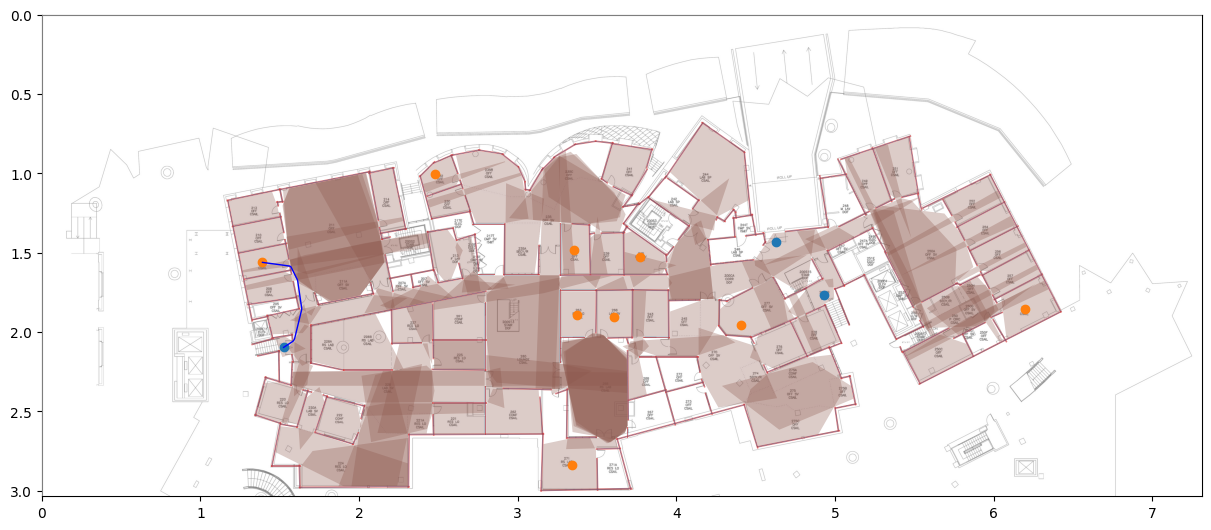

In [12]:
ax.plot(pos[:, 0], pos[:, 1], color='blue', alpha=1, linewidth=1, zorder=10)
fig

In [13]:
# if __name__ == "__main__":
#     with ipdb.launch_ipdb_on_exception():
#         main()

In [25]:
def gcs_traj_opt(source, destination):
    
    gcs = GcsTrajectoryOptimization(2)

    tic = time.time()
    regions = gcs.AddRegions(regions=convex_sets, order=3)
    toc = time.time()
#     print(toc - tic)
    
    source = gcs.AddRegions([Point(source)], order=0)
    target = gcs.AddRegions([Point(destination)], order=0)
    gcs.AddEdges(source, regions)
    gcs.AddEdges(regions, target)
    
    gcs.AddTimeCost()
    gcs.AddPathLengthCost()
    gcs.AddVelocityBounds(lb=np.array([-0.1, -0.1]), ub=np.array([0.1, 0.1]))

    options = GraphOfConvexSetsOptions()
    options.preprocessing = True
    options.max_rounded_paths = 20
    start_time = time.time()
    traj, result = gcs.SolvePath(source, target, options)
    print(f"GCS solved in {time.time() - start_time} seconds")
    if not result.is_success():
        print("Could not find a feasible path from source to destination")
    
    return traj

def get_traj_duration(traj):
    return traj.end_time() - traj.start_time()

def get_traj_length(traj):
    step_size = 0.1
    timestamps = np.arange(traj.start_time(), traj.end_time(), step_size)
    
    pos = []
    for t in timestamps:
        pos.append(traj.value(t).reshape(1, 2)[0])
    pos = np.array(pos)

    path_length = 0
    for t in range(len(pos) - 1):
        path_length += np.linalg.norm(pos[t+1] - pos[t])
        
    return path_length

In [30]:
convex_sets = []    
for free_poly in free_polys:
    convex_sets.append(VPolytope(free_poly.T))

In [31]:
# We've shown that we can generate one path from a source to a target.
# To solve the scheduling problem, we need the following

# A) From each source to each destination -- 1)the time it takes to traverse the path AND 2)the length of the path.
# B) From each destination to any other destination -- 1)the time it takes to traverse the path AND 2)the length of the path.

# We need B because we might have trajectories where a robot drops something off at a destination 
# and then goes to another destination.

time_srcs_to_dests = np.zeros((len(srcs), len(dests)))
length_srcs_to_dests = np.zeros((len(srcs), len(dests)))

In [33]:
for i in range(len(srcs)):
    for j in range(len(dests)):
        print(srcs[i], " ", dests[j], flush=True)
        traj = gcs_traj_opt(srcs[i], dests[j])
        time_srcs_to_dests[i][j] = get_traj_duration(traj)
        length_srcs_to_dests[i][j] = get_traj_length(traj)
        print(time_srcs_to_dests[i][j], " ", length_srcs_to_dests[i][j])

[1.524 2.096]   [1.388 1.56 ]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 22 rounding trials.


GCS solved in 10.154791593551636 seconds
7.129000270286466   0.7422646329025553
[1.524 2.096]   [6.2   1.856]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 10.72490906715393 seconds
48.7982950373885   5.076162110576149
[1.524 2.096]   [4.404 1.952]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.594568490982056 seconds
31.946704310941765   3.278823628327835
[1.524 2.096]   [3.344 2.84 ]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 10.441782236099243 seconds
22.809414566109155   2.4632527294500823
[1.524 2.096]   [2.48  1.004]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.67521595954895 seconds
26.294220075987035   2.7726674098976023
[1.524 2.096]   [3.352 1.481]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.265710592269897 seconds
22.612721238481395   2.3601642283964894
[1.524 2.096]   [3.768 1.525]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.366764545440674 seconds
28.336582453661155   2.8868156253165185
[1.524 2.096]   [3.604 1.905]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 10.610263109207153 seconds
21.380474683128014   2.360680045993299
[1.524 2.096]   [3.376 1.889]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 11.42825174331665 seconds
20.736195086718684   2.2043518751433897
[4.932 1.768]   [1.388 1.56 ]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.613142490386963 seconds
35.43999951593544   3.709395954127616
[4.932 1.768]   [6.2   1.856]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 8.285330772399902 seconds
17.485412113591252   1.8535022106719359
[4.932 1.768]   [4.404 1.952]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 100 rounding trials.


GCS solved in 7.538110733032227 seconds
5.280001853639695   0.5514573873954044
[4.932 1.768]   [3.344 2.84 ]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.472224712371826 seconds
27.799999893573872   2.958933599732196
[4.932 1.768]   [2.48  1.004]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.860116720199585 seconds
26.98815738617731   2.8324887058724206
[4.932 1.768]   [3.352 1.481]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 21 rounding trials.


GCS solved in 10.124561309814453 seconds
22.28777478018055   2.2885414098174244
[4.932 1.768]   [3.768 1.525]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 23 rounding trials.


GCS solved in 7.21729040145874 seconds
11.640001795112635   1.2426654403002784
[4.932 1.768]   [3.604 1.905]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.00590991973877 seconds
24.94890926444597   2.6568274189691
[4.932 1.768]   [3.376 1.889]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 10.377909660339355 seconds
24.91387893181451   2.6224032259397463
[4.628 1.432]   [1.388 1.56 ]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.470487594604492 seconds
32.39999758911199   3.316014490882633
[4.628 1.432]   [6.2   1.856]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 21 rounding trials.


GCS solved in 7.262822151184082 seconds
17.741557497540434   1.857354290388973
[4.628 1.432]   [4.404 1.952]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 100 rounding trials.


GCS solved in 7.204192161560059 seconds
5.2000016454142015   0.5661942430232484
[4.628 1.432]   [3.344 2.84 ]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.30218505859375 seconds
24.760000432396275   2.6557674399933298
[4.628 1.432]   [2.48  1.004]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 10.831501483917236 seconds
23.948158697864844   2.5255320027545127
[4.628 1.432]   [3.352 1.481]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.405362129211426 seconds
18.998171613354426   1.95240270415867
[4.628 1.432]   [3.768 1.525]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 52 rounding trials.


GCS solved in 7.7894127368927 seconds
8.600000775428388   0.9108617820381475
[4.628 1.432]   [3.604 1.905]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.002246379852295 seconds
21.97108996763636   2.361645480741824
[4.628 1.432]   [3.376 1.889]


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.80241060256958 seconds
21.873878443511632   2.3862741868366513


In [36]:
print(time_srcs_to_dests)
print(length_srcs_to_dests)

[[ 7.12900027 48.79829504 31.94670431 22.80941457 26.29422008 22.61272124
  28.33658245 21.38047468 20.73619509]
 [35.43999952 17.48541211  5.28000185 27.79999989 26.98815739 22.28777478
  11.6400018  24.94890926 24.91387893]
 [32.39999759 17.7415575   5.20000165 24.76000043 23.9481587  18.99817161
   8.60000078 21.97108997 21.87387844]]
[[0.74226463 5.07616211 3.27882363 2.46325273 2.77266741 2.36016423
  2.88681563 2.36068005 2.20435188]
 [3.70939595 1.85350221 0.55145739 2.9589336  2.83248871 2.28854141
  1.24266544 2.65682742 2.62240323]
 [3.31601449 1.85735429 0.56619424 2.65576744 2.525532   1.9524027
  0.91086178 2.36164548 2.38627419]]


In [37]:
time_dests_to_dests = np.zeros((len(dests), len(dests)))
length_dests_to_dests = np.zeros((len(dests), len(dests)))

In [38]:
for i in range(len(dests)):
    for j in range(len(dests)):
        if i <= j:
            print(i, " ", j, flush=True)
            if ((dests[i] == dests[j]).all()):
                time_dests_to_dests[i][j] = 0
                length_dests_to_dests[i][j] = 0
            else:
                traj = gcs_traj_opt(dests[i], dests[j])
                time_dests_to_dests[i][j] = get_traj_duration(traj)
                length_dests_to_dests[i][j] = get_traj_length(traj)
                print(time_dests_to_dests[i][j], " ", length_dests_to_dests[i][j])

0   0
0   1


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.331035375595093 seconds
50.15829411420172   5.368135983572428
0   2


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.143396615982056 seconds
33.30670523855999   3.3747062294918035
0   3


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 10.14787244796753 seconds
25.542916487994972   2.954696348551971
0   4


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.07151174545288 seconds
27.654220048590062   2.86724293231104
0   5


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 10.05705738067627 seconds
22.704236279325226   2.3453930358934385
0   6


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 10.463969469070435 seconds
28.036920437289005   2.8407630850104177
0   7


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 10.844112873077393 seconds
22.243096897739   2.5559533349014294
0   8


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 10.476062536239624 seconds
22.150919053456892   2.5900380558295857
1   1
1   2


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 21 rounding trials.


GCS solved in 7.937835931777954 seconds
20.976311062064525   2.325051471283013
1   3


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.946028470993042 seconds
43.21638077307313   4.585386311714099
1   4


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.662591934204102 seconds
41.95605367160189   4.395933542934431
1   5


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 10.456269025802612 seconds
37.006070583482206   3.891259724095616
1   6


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 7.949066638946533 seconds
26.35829736391779   2.7486296110655926
1   7


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 10.371625423431396 seconds
40.63642589673198   4.300580221756459
1   8


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 10.505482912063599 seconds
40.26204688753278   4.283197343306992
2   2
2   3


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.264859676361084 seconds
25.666706634778052   2.72441030564049
2   4


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.932677984237671 seconds
24.854863941619826   2.5764036875261933
2   5


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.865018606185913 seconds
19.9048788904091   2.0144671122263476
2   6


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 30 rounding trials.


GCS solved in 8.07145643234253 seconds
9.506706783591627   0.9884479120957969
2   7


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.490019798278809 seconds
22.872761928059454   2.409043478854743
2   8


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.549025297164917 seconds
22.751808681806217   2.3491969587956967
3   3
3   4


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.194612264633179 seconds
22.13422179714643   2.4124884530569717
3   5


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.77195954322815 seconds
17.184235876523463   1.850368460580955
3   6


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 10.030831336975098 seconds
20.430535085740278   2.1964134820741426
3   7


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 100 rounding trials.


GCS solved in 10.163689851760864 seconds
9.350001892601709   1.0083969119807552
3   8


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 23 rounding trials.


GCS solved in 9.434900522232056 seconds
9.510001011670964   1.0357013683333347
4   4
4   5


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 40 rounding trials.


GCS solved in 7.06899356842041 seconds
9.69211715726113   1.0339764180129591
4   6


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 21 rounding trials.


GCS solved in 9.754202604293823 seconds
19.585078353234405   2.0441741626172667
4   7


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 8.609572410583496 seconds
19.119254101029203   2.105726205673132
4   8


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.165496349334717 seconds
19.022043450066832   2.043919818940705
5   5
5   6


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 24 rounding trials.


GCS solved in 9.439728021621704 seconds
14.635095551578562   1.4792398762805805
5   7


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.97942852973938 seconds
14.164236565678294   1.5333627720636607
5   8


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.7310209274292 seconds
14.100428697904084   1.4900452389409624
6   6
6   7


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 20 rounding trials.


GCS solved in 9.573013305664062 seconds
17.602978157492604   1.8909410595352405
6   8


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 21 rounding trials.


GCS solved in 9.722991466522217 seconds
17.48202641119406   1.8219968463723022
7   7
7   8


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 100 rounding trials.


GCS solved in 12.90114140510559 seconds
2.370441165935813   0.3116066009200352
8   8


In [40]:
print(time_dests_to_dests)
print(length_dests_to_dests)

[[ 0.         50.15829411 33.30670524 25.54291649 27.65422005 22.70423628
  28.03692044 22.2430969  22.15091905]
 [ 0.          0.         20.97631106 43.21638077 41.95605367 37.00607058
  26.35829736 40.6364259  40.26204689]
 [ 0.          0.          0.         25.66670663 24.85486394 19.90487889
   9.50670678 22.87276193 22.75180868]
 [ 0.          0.          0.          0.         22.1342218  17.18423588
  20.43053509  9.35000189  9.51000101]
 [ 0.          0.          0.          0.          0.          9.69211716
  19.58507835 19.1192541  19.02204345]
 [ 0.          0.          0.          0.          0.          0.
  14.63509555 14.16423657 14.1004287 ]
 [ 0.          0.          0.          0.          0.          0.
   0.         17.60297816 17.48202641]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          2.37044117]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
[[0.         5

In [41]:
# Use symmetry to fill in the rest of the numbers since metric[i][j] should be equal to metric[j][i]
for i in range(len(dests)):
    for j in range(len(dests)):
        if i > j:
            time_dests_to_dests[i][j] = time_dests_to_dests[j][i]
            length_dests_to_dests[i][j] = length_dests_to_dests[j][i]

In [42]:
print(time_dests_to_dests)
print(length_dests_to_dests)

[[ 0.         50.15829411 33.30670524 25.54291649 27.65422005 22.70423628
  28.03692044 22.2430969  22.15091905]
 [50.15829411  0.         20.97631106 43.21638077 41.95605367 37.00607058
  26.35829736 40.6364259  40.26204689]
 [33.30670524 20.97631106  0.         25.66670663 24.85486394 19.90487889
   9.50670678 22.87276193 22.75180868]
 [25.54291649 43.21638077 25.66670663  0.         22.1342218  17.18423588
  20.43053509  9.35000189  9.51000101]
 [27.65422005 41.95605367 24.85486394 22.1342218   0.          9.69211716
  19.58507835 19.1192541  19.02204345]
 [22.70423628 37.00607058 19.90487889 17.18423588  9.69211716  0.
  14.63509555 14.16423657 14.1004287 ]
 [28.03692044 26.35829736  9.50670678 20.43053509 19.58507835 14.63509555
   0.         17.60297816 17.48202641]
 [22.2430969  40.6364259  22.87276193  9.35000189 19.1192541  14.16423657
  17.60297816  0.          2.37044117]
 [22.15091905 40.26204689 22.75180868  9.51000101 19.02204345 14.1004287
  17.48202641  2.37044117  0.  

In [43]:
with open("time_srcs_to_dests.pkl", "wb") as f:
    pickle.dump(time_srcs_to_dests, f)
with open("length_srcs_to_dests.pkl", "wb") as f:
    pickle.dump(length_srcs_to_dests, f)
    
with open("time_dests_to_dests.pkl", "wb") as f:
    pickle.dump(time_dests_to_dests, f)
with open("length_dests_to_dests.pkl", "wb") as f:
    pickle.dump(length_dests_to_dests, f)